In [2]:
import csv
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import svm
from pyod.models.knn import KNN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from pyod.utils.utility import standardizer
from statsmodels.tsa.stattools import grangercausalitytests
from pyod.models.combination import aom, moa, average, maximization

In [4]:
## read topline data
tmp_lst = []
with open('topline_metrics.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        tmp_lst.append(row)

In [5]:
topline = pd.DataFrame(tmp_lst[1:], columns = tmp_lst[0]) 
## inspect topline structure
topline.head()

,Date,Date,Platform,Country,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds)
0,2018-03-15,2018-03-15,Android(All),Kazakhstan(哈萨克斯坦),628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18
1,2018-03-15,2018-03-15,ALL,United States(美国),633293.54,19939.05,43429.11,3428.09,17.58,1.3,2.3,4527.01,75.65,58.87
2,2018-03-15,2018-03-15,Android(All),Kazakhstan(哈萨克斯坦),628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18
3,2018-03-15,2018-03-15,ALL,Guatemala(危地马拉),628976.03,15621.54,43429.11,3428.09,17.58,1.3,2.3,4527.01,74.62,46.21
4,2018-03-15,2018-03-15,Android(All),Belarus(白俄罗斯),629154.54,15800.04,43429.11,3428.09,17.58,1.3,2.3,4527.01,76.97,56.92


In [6]:
## drop redundant columns
topline = topline.loc[:, ~topline.columns.duplicated()]

In [7]:
## transform data type
topline['Date'] = pd.to_datetime(topline['Date'], errors = 'coerce')
modify = ['TRU', 'DAU', 'Items', 'Trans', 'Items Per Trans', 'Items per DAU', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)']
for item in modify:
    topline[item] = pd.to_numeric(topline[item], errors = 'coerce')  

In [8]:
## deal with negative time spend issue
warnings.filterwarnings('ignore')
n = len(topline)
for i in range(n):
    if topline['Time Spend Per Day(seconds)'][i] < 0:
        topline['Time Spend Per Day(seconds)'][i] = 0

In [18]:
## Anomaly Detection
## construct standardized features
## only keeps linearly independent columns
feature = topline[['TRU', 'DAU', 'Items', 'Trans', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)']]
feature = standardizer(np.array(feature))

In [19]:
## use KNN to detect outliers
## try the number of neighbors from 10 to 100
k_num = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
clf_num = len(k_num)
score = np.zeros([feature.shape[0], clf_num])

for i in range(clf_num):
    k = k_num[i]
    clf = KNN(n_neighbors = k, method = 'largest')
    clf.fit(feature)
    ## store the results in each column:
    score[:, i] = clf.decision_scores_
    
## normalize decision scores
score = standardizer(score)

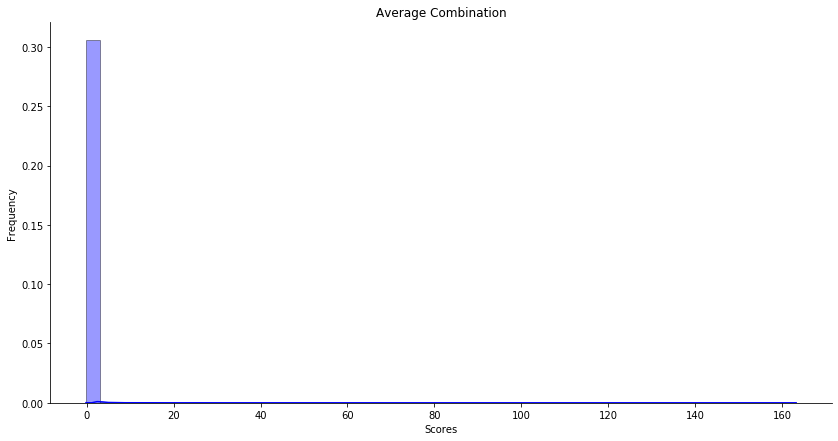

In [22]:
## use four common methods for anomaly detecting criterion
## average
score_avg = average(score)

## draw histogram of average scores
f, ax = plt.subplots(figsize = (14,7))
sns.distplot(score_avg, kde = True, rug = False,
             color = 'blue', 
             hist_kws = {'edgecolor' : 'black'},
             ax = ax);
ax.axes.set_xlabel("Scores")
ax.axes.set_ylabel("Frequency")
ax.set_title('Average Combination', fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [23]:
## set 95% quantile as cut off point
df = topline[['TRU', 'DAU', 'Items', 'Trans', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)']]
cut_off = np.round(np.percentile(score_avg, 95), 1)

In [24]:
warnings.filterwarnings('ignore')
df['score'] = score_avg
df['class'] = np.where(df['score'] < cut_off, 0, 1)

In [25]:
## summary the number of anomaly values
df['class'].value_counts()

0    711552
1     36712
Name: class, dtype: int64

In [26]:
df.groupby('class').mean()

,TRU,DAU,Items,Trans,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds),score
class,,,,,,,,,
0,6.658717e+05,16404.520124,45555.259552,3566.553869,2.781201,4690.389776,39.667309,122.124305,-0.064989
1,2.175874e+06,52378.074755,154312.367910,11555.070437,5.244063,12905.635015,42.271003,132.087028,1.259619


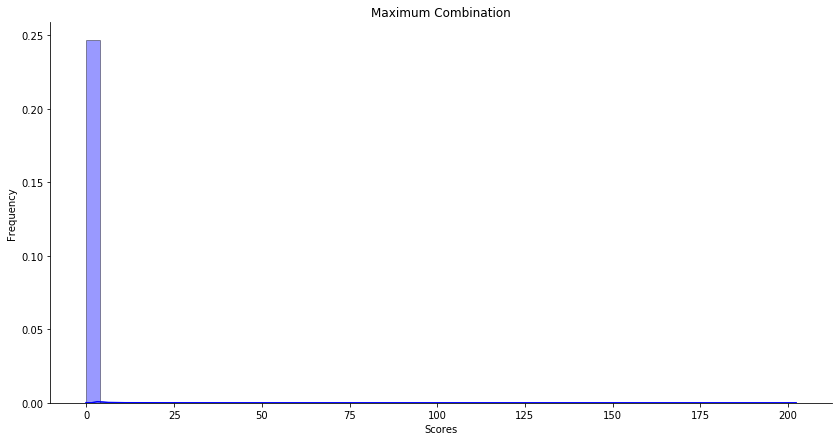

In [27]:
## maximum
score_max = maximization(score)

## draw histogram of maximum scores
f, ax = plt.subplots(figsize = (14,7))
sns.distplot(score_max, kde = True, rug = False,
             color = 'blue', 
             hist_kws = {'edgecolor' : 'black'},
             ax = ax);
ax.axes.set_xlabel("Scores")
ax.axes.set_ylabel("Frequency")
ax.set_title('Maximum Combination', fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [28]:
df = topline[['TRU', 'DAU', 'Items', 'Trans', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)']]
df['score'] = score_max
df['class'] = np.where(df['score'] < cut_off, 0, 1)
## summary the number of anomaly values
df['class'].value_counts()

0    703794
1     44470
Name: class, dtype: int64

In [29]:
df.groupby('class').mean()

,TRU,DAU,Items,Trans,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds),score
class,,,,,,,,,
0,6.623501e+05,16300.407485,45275.928154,3550.220718,2.772797,4670.222008,39.638897,121.944911,-0.055224
1,1.968182e+06,47750.033691,139759.953141,10419.929042,4.947420,11791.627403,42.266427,133.188124,1.330559


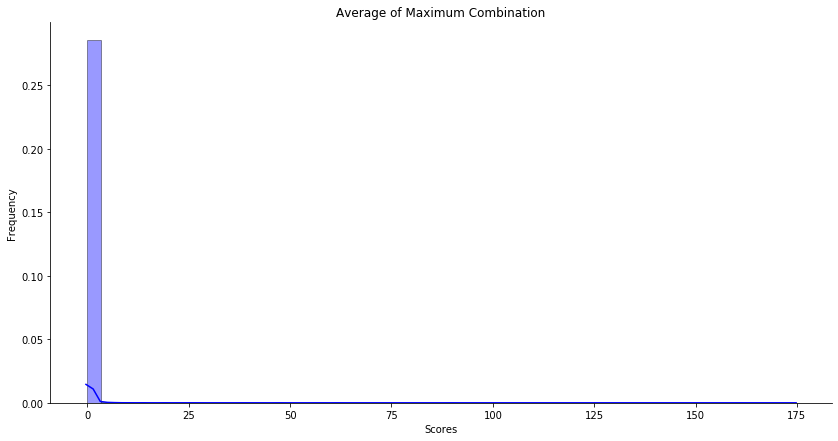

In [171]:
## average of maximum
score_aom = aom(score)

## draw histogram of average maximum scores
f, ax = plt.subplots(figsize = (14,7))
sns.distplot(score_aom, kde = True, rug = False,
             color = 'blue', 
             hist_kws = {'edgecolor' : 'black'},
             ax = ax);
ax.axes.set_xlabel("Scores")
ax.axes.set_ylabel("Frequency")
ax.set_title('Average of Maximum Combination', fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [172]:
df = topline[['TRU', 'DAU', 'Items', 'Trans', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)']]
df['score'] = score_aom
df['class'] = np.where(df['score'] < cut_off, 0, 1)
## summary the number of anomaly values
df['class'].value_counts()

0    709542
1     38722
Name: class, dtype: int64

In [173]:
df.groupby('class').mean()

,TRU,DAU,Items,Trans,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds),score
class,,,,,,,,,
0,6.648665e+05,16371.82823,45482.561054,3562.237274,2.778493,4685.251037,39.657158,122.038478,-0.061476
1,2.115911e+06,51109.78869,149999.079586,11219.496014,5.165853,12573.356425,42.321852,133.142579,1.290537


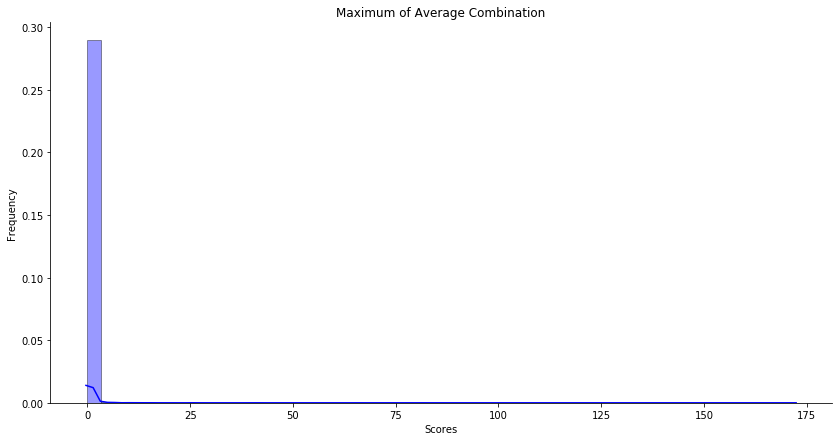

In [174]:
## maximum of average
score_moa = moa(score)

## draw histogram of maximum average scores
f, ax = plt.subplots(figsize = (14,7))
sns.distplot(score_moa, kde = True, rug = False,
             color = 'blue', 
             hist_kws = {'edgecolor' : 'black'},
             ax = ax);
ax.axes.set_xlabel("Scores")
ax.axes.set_ylabel("Frequency")
ax.set_title('Maximum of Average Combination', fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [175]:
df = topline[['TRU', 'DAU', 'Items', 'Trans', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)']]
df['score'] = score_moa
df['class'] = np.where(df['score'] < cut_off, 0, 1)
## summary the number of anomaly values
df['class'].value_counts()

0    708109
1     40155
Name: class, dtype: int64

In [176]:
df.groupby('class').mean()

,TRU,DAU,Items,Trans,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds),score
class,,,,,,,,,
0,6.641309e+05,16352.682583,45420.331363,3558.524567,2.776976,4680.800116,39.656408,122.039040,-0.061118
1,2.077100e+06,50207.726884,147366.611234,11011.704950,5.107404,12370.345135,42.239994,132.736393,1.295205


In [22]:
## K-means clustering
## since Items per Trans and Items per DAU are not consistent with Items, Trans and DAU
## we do not take them into consideration when clustering
## select the number of groups based on Within Cluster Sum of Squares
k_num = [i for i in range(2, 11)]
wcss = []

In [24]:
for k in k_num:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(feature)
    wcss.append(kmeans.inertia_)

In [25]:
wcss

[4621517.615078698,
 4063993.57826344,
 3643674.623414933,
 3143702.0676490115,
 2724191.6060323804,
 2512411.7015602984,
 2284802.8691325663,
 2106322.192768477,
 1952827.7086849117]

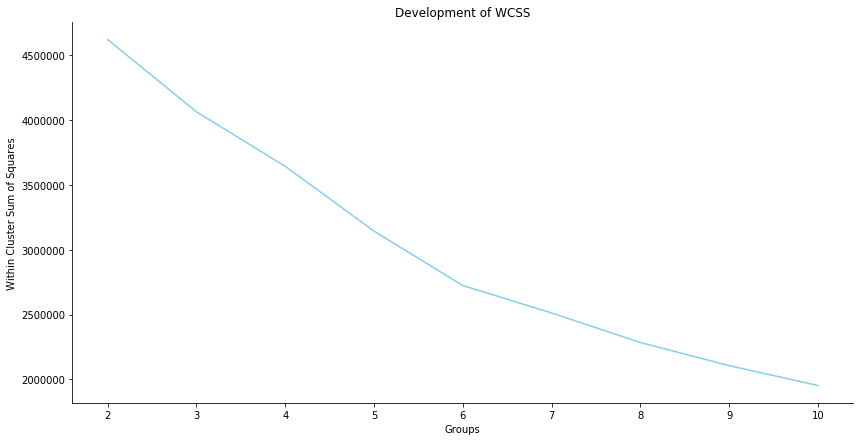

In [27]:
## draw a plot of wcss
f, ax = plt.subplots(figsize = (14,7))
plt.plot(k_num, wcss, color = 'skyblue')
ax.axes.set_xlabel("Groups")
ax.axes.set_ylabel("Within Cluster Sum of Squares")
ax.set_title('Development of WCSS', fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [29]:
## assign six groups according to WCSS
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
cluster = kmeans.fit_predict(feature)

In [32]:
## add clusters information to topline
topline['cluster'] = cluster

In [35]:
## visualize clusters using Principal Component Analysis
pca = PCA(n_components = 2)
p_components = pca.fit_transform(feature)
principalDf = pd.DataFrame(data = p_components, columns = ['principal component 1', 'principal component 2'])

In [37]:
## combine cluster information
df = pd.concat([principalDf, topline[['cluster']]], axis = 1)

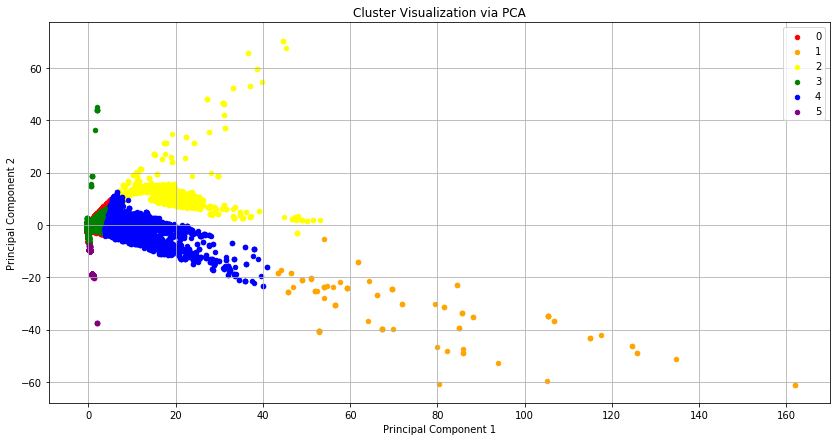

In [47]:
## visualize 2D projection
f, ax = plt.subplots(figsize = (14,7))
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Cluster Visualization via PCA', fontsize = 12)
clusters = [0, 1, 2, 3, 4 ,5]
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
for item, color in zip(clusters, colors):
    idx = df['cluster'] == item
    ax.scatter(df.loc[idx, 'principal component 1']
               , df.loc[idx, 'principal component 2']
               , c = color, s = 20)
ax.legend(clusters)
ax.grid()

In [48]:
## together two principal components roughly contain 53.35% information
pca.explained_variance_ratio_

array([0.39210567, 0.14135936])

In [108]:
## Model Prediction
## split training and validation data
y_label = topline['cluster'].tolist()

In [109]:
np.random.seed(123) 
np.random.shuffle(feature) 
np.random.seed(123) 
np.random.shuffle(y_label) 

In [110]:
## set aside a validation set 
x_validation = feature[:100000] 
x_training = feature[100000:]  
y_validation = y_label[:100000] 
y_training = y_label[100000:] 

In [114]:
## use SVM to do classification
clf = svm.SVC(decision_function_shape = "ovo")
clf.fit(x_training, y_training)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [115]:
## compute training and validation accuracy scores
p_training = clf.predict(x_training)
p_validation = clf.predict(x_validation)
## accuracy score of training data is almost 1, which means training data is linearly separable
accuracy_score(y_training, p_training)

0.9993536583860896

In [116]:
## accuracy score of validation data is 0.99926, fairly high
accuracy_score(y_validation, p_validation)

0.99926

In [130]:
## when new data appears, just use clf.predict to do the prediction

In [13]:
## Time Series Causation Graph Analysis
## take average over all regions in a given date
ts = topline[['Date', 'TRU', 'DAU', 'Items', 'Trans', 'Items Per Trans', 'Items per DAU', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)']]

In [14]:
ts = ts.groupby('Date').mean().reset_index()

In [16]:
## output csv after taking average
ts.to_csv ('output.csv', index = False, header = True)

In [133]:
## find correlations between variables
ts_corr = ts[['TRU', 'DAU', 'Items', 'Trans', 'Items Per Trans', 'Items per DAU', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)']]
corr = ts_corr.corr()

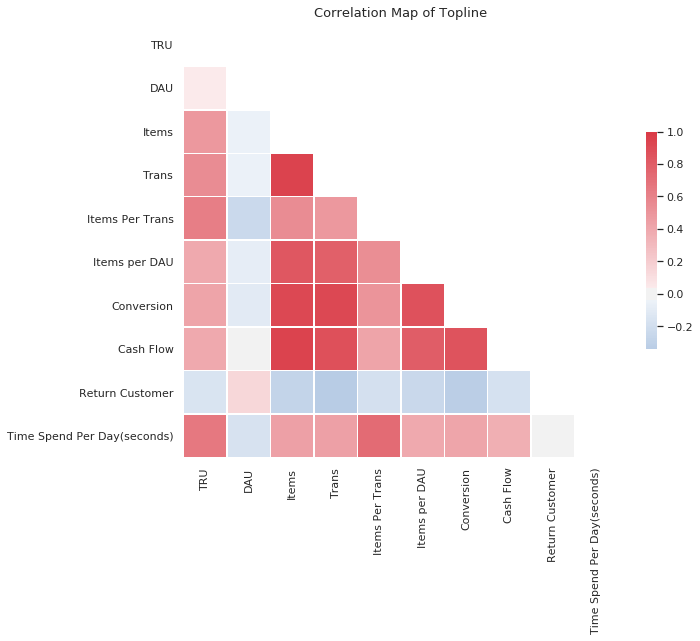

In [143]:
## visualize the correlations
sns.set(style = "white")

## generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype = np.bool))
f, ax = plt.subplots(figsize=(10, 8))
## generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap = True) 

## draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5})
ax.set_title("Correlation Map of Topline" , fontsize = 13);

In [156]:
## correlation map may give us intuitions about causations 
## e.g. Items, Trans, Conversion could exert positive influence on Cash Flow
## plot time series of key factors
ts_p = topline[['Date', 'TRU', 'DAU', 'Items', 'Trans', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)']]
ts_p = ts_p.groupby('Date').mean()

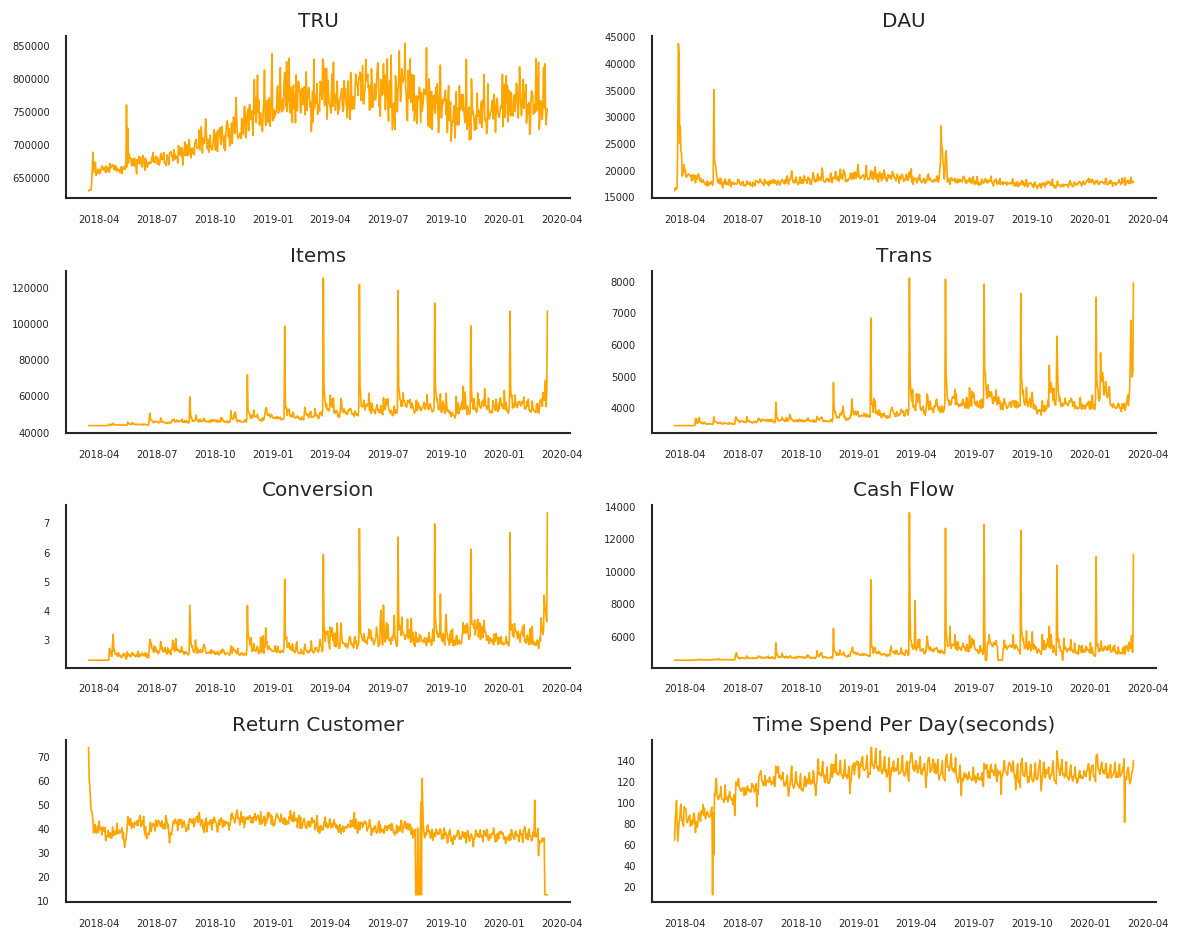

In [157]:
f, axes = plt.subplots(nrows = 4, ncols = 2, dpi = 120, figsize = (10, 8))
for i, ax in enumerate(axes.flatten()):
    data = ts_p[ts_p.columns[i]]
    ax.plot(data, color = 'orange', linewidth = 1)
    ax.set_title(ts_p.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(labelsize = 6)
    plt.tight_layout();

In [161]:
## from the time series pattern we can generally draw a conclusion
## Items, Trans, Conversion, Cash Flow could interchangeably cause each other
## from 2009, these four variables will dramatically increase and then back to normal every three months
## Tru may have causation with these four variables, but the relationships are not obvious
## use Granger's Causality Test for quantitive measurement

In [168]:
ts = ts[['TRU', 'DAU', 'Items', 'Trans', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)']]

In [170]:
maxlag = 14
def granger(data, variables, test = 'ssr_chi2test'):
    mat = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)
    for i in mat.columns:
        for j in mat.index:
            res = grangercausalitytests(data[[j, i]], maxlag = maxlag, verbose = False)
            p_values = [round(res[k + 1][0][test][1], 4) for k in range(maxlag)]
            min_p = np.min(p_values)
            mat.loc[j, i] = min_p
    mat.columns = [item + '_x' for item in variables]
    mat.index = [item + '_y' for item in variables]
    return mat


In [172]:
g_mat = granger(ts, ts.columns)
g_mat

,TRU_x,DAU_x,Items_x,Trans_x,Conversion_x,Cash Flow_x,Return Customer_x,Time Spend Per Day(seconds)_x
TRU_y,1.000,0.0002,0.0003,0.0037,0.0000,0.0084,0.0024,0.0000
DAU_y,0.000,1.0000,0.1155,0.0649,0.0285,0.2884,0.0000,0.0000
Items_y,0.000,0.0292,1.0000,0.0000,0.0137,0.0000,0.0000,0.0000
Trans_y,0.000,0.0224,0.0000,1.0000,0.0971,0.0000,0.0000,0.0002
Conversion_y,0.000,0.0113,0.0782,0.0000,1.0000,0.0000,0.0000,0.0015
Cash Flow_y,0.000,0.1260,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Return Customer_y,0.007,0.0966,0.0187,0.0000,0.0002,0.4996,1.0000,0.0071
Time Spend Per Day(seconds)_y,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0005,1.0000


In [173]:
## take p-value 0.05 as critical value
## roughly all variables could interchangeably cause each other except DAU and Return Customer
## DAU and Return Customer are more independent

In [177]:
## Findings and Story
## EDA
## summary statistics
topline.describe().T
## time spend per day has mean 122.61 and standard deviation 43.31, which is comparably stable
## other variables have similar mean and standard deviation, indicating high volatility
## little question about unconsistency in Items, Trans and Items Per Trans and DAU, Items Per DAU

,count,mean,std,min,25%,50%,75%,max
TRU,748264.0,739956.808902,677659.535206,628647.81,628810.19,631445.16,657473.46,26776754.43
DAU,748264.0,18169.486951,18017.989031,15292.17,15296.77,15373.93,16176.63,2141935.13
Items,748264.0,50891.198421,46102.406669,43429.11,43429.11,43521.24,44660.21,4387411.60
Trans,748264.0,3958.493640,3655.625040,3428.09,3428.09,3433.85,3522.53,434846.58
Items Per Trans,748264.0,31.569433,23.629177,17.58,17.58,28.09,36.08,1744.87
Items per DAU,748264.0,1.414330,1.208879,1.30,1.30,1.32,1.39,444.24
Conversion,748264.0,2.902036,2.591666,2.30,2.30,2.56,3.00,232.63
Cash Flow,748264.0,5093.453512,4712.790645,4527.01,4527.01,4532.77,4611.08,819825.28
Return Customer,748264.0,39.795054,24.796009,12.21,28.66,39.43,48.92,3912.09
Time Spend Per Day(seconds),748264.0,122.613105,43.309813,0.00,98.95,118.18,139.37,1390.06


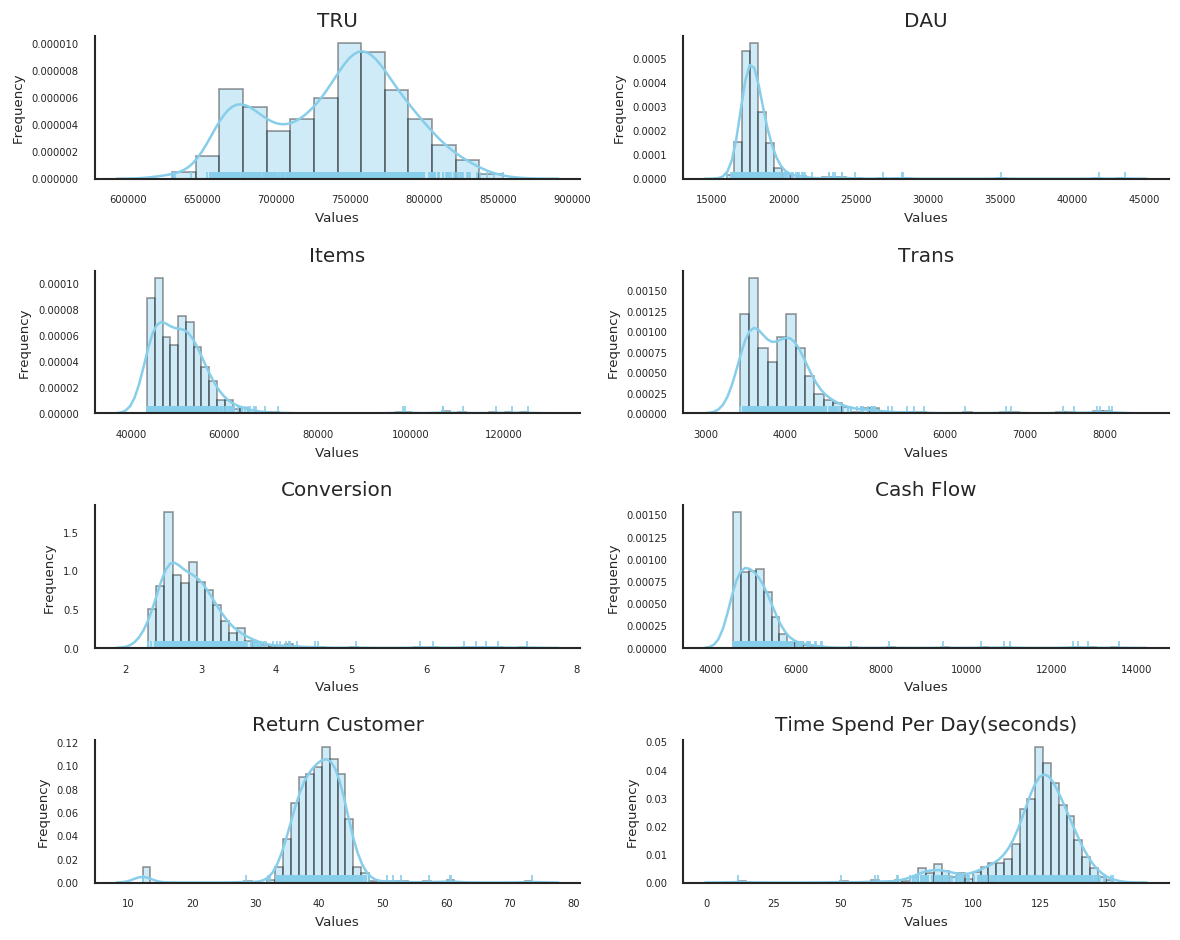

In [183]:
## move on to specific distribution
## plot histograms 
f, axes = plt.subplots(nrows = 4, ncols = 2, dpi = 120, figsize = (10, 8))
for i, ax in enumerate(axes.flatten()):
    data = ts[ts.columns[i]]
    sns.distplot(data, kde = True, rug = True,
             color = 'skyblue', 
             hist_kws = {'edgecolor' : 'black'},
             ax = ax);
    ax.axes.set_xlabel("Values", fontsize = 8)
    ax.axes.set_ylabel("Frequency", fontsize = 8)
    ax.set_title(ts_p.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(labelsize = 6)
    plt.tight_layout();

In [184]:
## TRU and Time Spend Per Day(seconds) follow bimodal distribution, indicating there might exist two classes
## Return Customer follows normal distribution with mean 40 and variance 615
## Items, Trans, Conversion, Cash Flow could follow gamma distribution with similar parameters but different magnitude
## DAU may follow gamma distribution with different parameters
## we could use Items, Trans, Conversion to predict Cash Flow 

In [191]:
X = ts[['TRU', 'DAU', 'Items', 'Trans', 'Conversion', 'Return Customer', 'Time Spend Per Day(seconds)']]
Y = ts[['Cash Flow']]

In [192]:
## run OLS regression
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Cash Flow   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1056.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        23:31:43   Log-Likelihood:                -5004.8
No. Observations:                 724   AIC:                         1.003e+04
Df Residuals:                     716   BIC:                         1.006e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         276.8374    191.304      1.447      0.148     -98.747     652.422
TRU                            -0.0011      0.000     -3.738      0.000      -0.002      -0.001
DAU                             0.0095      0.005      1.817      0.070      -0.001       0.020
Items                           0.1058      0.004     28.046      0.000       0.098       0.113
Trans                          -0.1178      0.062     -1.905      0.057      -0.239       0.004
Conversion                     78.1021     48.145      1.622      0.105     -16.419     172.624
Return Customer                14.0061      1.991      7.035      0.000      10.098      17.915
Time Spend Per Day(seconds)    -1.7952      0.842     -2.131      0.033      -3.449      -0.141
==============================================================================
Omnibus:                      433.186   Durbin-Watson:                   1.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47025.983
Skew:                           1.735   Prob(JB):                         0.00
Kurtosis:                      42.330   Cond. No.                     1.56e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [193]:
## adjusted R square reaches 0.91 which means model fits pretty well
## F test is rejected, indicating overall variables are statistically significant
## TRU, Items, Return Customer and Time Spent Per Day reject T test under significance level 0.05
## they exert statistically significant influence on Cash Flow

In [194]:
## Strategies for increaing Cash Flow:
## launch features which could increase Items, Return Customer and decrease TRU, Time Spent Per Day 
## make use of three month's seasonality trend in Cash Flow, considering causations among Items, Trans and Conversation
## implement different strategies according to different clusters